<p> <center> <h1>Mars Exploration: Local Search </h1> </center> </p>

<br><br>

An important source of information for the exploration of Mars are the images obtained with orbiters that are continuously sending information about the surface of our neighboring planet. A large number of high-resolution images captured by various satellites with instruments capable of measuring the depth and other characteristics of the Martian soil are available on the HiRISE page. These data helped determine the place where the Perseverance Rover landed on the last mission carried out by NASA on the red planet.

The following figure is the 3D representation of a small part of the surface of Mars. The axes represent distances in meters, and the colors indicate the deepest (in red) and highest (in light yellow) parts. The deepest part of the surface shown is taken as level 0. This data is located on the HiRISE site.

<div style="text-align: center;">
  <div style="display: inline-block;">
    <img src="mars_2D.png" width="600"/>
  </div>
</div>

The information shown above can be represented in an image like the one shown below. The color of each pixel in the image represents the height at that position. Sections in gray represent areas where there is no satellite information.

<div style="text-align: center;">
  <div style="display: inline-block;">
    <img src="mars_3D.png" height="500"/>
  </div>
</div>

Data on the HiRISE site is available in IMG files with topographic information. In the original files, the above surface has dimensions of 7163 pixels wide and 1070 pixels high. Each pixel represents an area of 1.0045 meters x 1.0045 meters. These data are not RGB colors, they are height values, and the image displayed is known as a false color image, since it is artificially constructed by assigning a color to each pixel according to some dimension or measurement (in this case, depth values or height). These images are called height maps. Values in gray have a height value of -1, and represent areas where there is no valid information.

The displayed surface data file is provided in the file named 'mars_map.IMG'. Because the data file size is around 1Gb, the original image is scaled to a smaller size. With this, the images shown have dimensions of 717 x 1077, and each pixel represents an area of 1.0045 meters x 1.0045 meters.

<br>

<p><h4> <b>Introduction</b> </h4></p>

It is theorized that at the bottom of some of the craters on the Martian surface it is possible to find water and other interesting elements that could answer the question of whether there ever was life on Mars or if there is life now. Therefore, it is interesting to see the possibility that some of the rover explorers will be able to navigate safely to these craters and reach the bottom of them.

Consider that there is a group of engineers who want to determine the type of explorer that could accomplish the task of descending a crater successfully. The exploring robot that they want to send is only capable of using information from its surroundings to make decisions. That is, it will only know the depth in its vicinity. Therefore, the engineers decided that in the simulations, if the explorer is in a certain pixel of the image, it will only be able to know the depth in the eight neighboring pixels. Additionally, to avoid damage to the robot, the explorer is not allowed to move to pixels with a height difference greater than 2.0 meters from its current position.

To carry out the descent simulations, as a first approximation, it is desired to test local search algorithms such as greedy search and simulated annealing as decision-making mechanisms of the robot.

<br>

<p><h4> <b>Problem 1: Greedy Search</b> </h4></p>

Implement a greedy or greedy search algorithm, with which, given an initial position in the crater image, the explorer searches for a descent path to reach the deepest part of the crater. One way to implement said algorithm would be the following:
- Given the pixel where the explorer is located, check the depths of the eight neighboring pixels of that position.
- Choose the pixel that has the smallest possible depth, but the difference between the current height and that of the neighboring position is no more than 2.0 meters. If this depth is better than the current one, move the explorer to that position.
- Repeat the same until the explorer is not able to find a better position.

Test your algorithm at the position x = 3350 meters y = 5800 meters. And answer: How far is the explorer capable of going?

Subsequently, test your algorithm with five other positions near and far from the crater floor. And answer: How good is the algorithm for reaching the bottom of the crater in the tested cases?

In [118]:
# Import the required libraries
import copy
import numpy as np
import random
import math
from skimage.transform import downscale_local_mean
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import plotly.graph_objects as px
import warnings

In [119]:
# Function to preprocess and visualize the height map of the landscape
def process_height_map(input_file, output_file):
    # Open the data file
    data_file = open(input_file, "rb")

    # Parse header information
    endHeader = False
    while not endHeader:
        line = data_file.readline().rstrip().lower()

        sep_line = line.split(b'=')
        
        if len(sep_line) == 2:
            itemName = sep_line[0].rstrip().lstrip()
            itemValue = sep_line[1].rstrip().lstrip()

            # Extract information from header
            if itemName == b'valid_maximum':
                maxV = float(itemValue)
            elif itemName == b'valid_minimum':
                minV = float(itemValue)
            elif itemName == b'lines':
                n_rows = int(itemValue)
            elif itemName == b'line_samples':
                n_columns = int(itemValue)
            elif itemName == b'map_scale':
                scale_str = itemValue.split()
                if len(scale_str) > 1:
                    scale = float(scale_str[0])

        elif line == b'end':
            endHeader = True
            # Move to the start of actual data
            char = 0
            while char == 0 or char == 32:
                char = data_file.read(1)[0] 
            pos = data_file.seek(-1, 1)     

    # Read and preprocess image data
    image_size = n_rows * n_columns
    data = data_file.read(4 * image_size)
    image_data = np.frombuffer(data, dtype=np.dtype('f'))
    image_data = image_data.reshape((n_rows, n_columns)).astype('float64')
    image_data -= minV
    image_data[image_data < -10000] = -1

    # Subsample the image
    sub_rate = round(10 / scale) 
    image_data = downscale_local_mean(image_data, (sub_rate, sub_rate))
    image_data[image_data < 0] = -1

    print('Sub-sampling:', sub_rate)
    new_scale = scale * sub_rate
    print('New scale:', new_scale, 'meters/pixel')

    # Save preprocessed map
    np.save(output_file, image_data)

    # Load preprocessed height map
    image_data = np.load(output_file)
    
    return image_data, scale, new_scale, maxV, minV, n_rows, n_columns


# Function to plot the map in 3D using Plotly
def plot3D(image_data, new_scale, maxV, minV, n_rows, n_columns):
    # Plot 3D surface
    x = np.arange(image_data.shape[1]) * new_scale
    y = np.arange(image_data.shape[0]) * new_scale
    X, Y = np.meshgrid(x, y)

    # Plot 3D surface using Plotly
    fig = px.Figure(data = px.Surface(x=X, y=Y, z=np.flipud(image_data), colorscale='hot', cmin=0, 
                                    lighting=dict(ambient=0.0, diffuse=0.8, fresnel=0.02, roughness=0.4, specular=0.2), 
                                    lightposition=dict(x=0, y=n_rows/2, z=2*maxV)),
                    layout = px.Layout(scene_aspectmode='manual', 
                                        scene_aspectratio=dict(x=1, y=n_rows/n_columns, z=max((maxV-minV)/x.max(), 0.2)), 
                                        scene_zaxis_range=[0, maxV-minV]))
    
    fig.show()


# Function to plot the map in 2D using Matplotlib
def plot2D(image_data, n_rows, n_columns, scale, new_scale, start=None, path=None, ax=None):   
    # Get last position reached from the path
    target = path.pop()
    
    # Plot surface image
    cmap = copy.copy(plt.cm.get_cmap('autumn'))
    cmap.set_under(color='black')   

    ls = LightSource(315, 45)
    rgb = ls.shade(image_data, cmap=cmap, vmin=0, vmax=image_data.max(), vert_exag=2, blend_mode='hsv')
    
    # Use matplotlib.colormaps.get_cmap(obj) instead of plt.cm.get_cmap('autumn')
    #cmap = copy.copy(plt.colormaps.get_cmap('autumn'))
    
    im = ax.imshow(rgb, cmap=cmap, vmin=0, vmax=image_data.max(), 
                   extent=[0, scale * n_columns, 0, scale * n_rows], 
                   interpolation='nearest', origin='upper')
    
    # Plot initial point and path
    if start and path:
        start_point = ax.scatter(start[1] * new_scale, n_rows - start[0] * new_scale, color='blue', label='Start Point', marker='o', s=40)
        end_point = ax.scatter(target[1] * new_scale, n_rows - target[0] * new_scale, color='green', label='End Point', marker='o', s=40)

        path_x, path_y = zip(*path)
        path_line = ax.plot(np.array(path_y) * new_scale, n_rows - np.array(path_x) * new_scale , color='deeppink', label='Path', linewidth=0.5)

        # Add legends
        ax.legend(handles=[start_point, end_point, path_line[0]], loc='best', fontsize=6)

    # Add color bar for height and set title and labels
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height (m)')
    ax.set_title('Mars surface')
    ax.set_xlabel('X (m)', fontstyle='italic')
    ax.set_ylabel('Y (m)', fontstyle='italic')


# Ignore warnings
warnings.filterwarnings("ignore")

In [120]:
# Function to calculate row and column from given coordinate
def calculate_row_col(x, y, new_scale, n_rows):
    row = n_rows - (y / new_scale)
    column = x / new_scale
    return (round(row), round(column))


def visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, ax=None, three_D=False):
    # Create a copy of the original map
    path_map = np.copy(mars_map)

    # Mark the path positions on the map
    for x, y in path:
        path_map[x, y] = 0 # Mark the path position with the lowest height 
        # path_map[x, y] = mars_map.max()  # Mark the path position with the maximum height 
    
    # Plot the path map
    if three_D:
        plot3D(path_map, new_scale, maxV, minV, n_rows, n_columns)
    else:
        plot2D(mars_map, n_rows, n_columns, scale, new_scale, start, path, ax)

In [121]:
# Function to perform greedy descent search
def greedyDescentSearch(start, mars_map, max_height_diff, max_iterations):
    # Define a list to store the descent path
    descent_path = [start]
    current_position = start

    # Define a function to check if a pixel is within bounds and satisfies height difference condition
    def isValidMove(row, col):
        return 0 <= row < mars_map.shape[0] and 0 <= col < mars_map.shape[1] \
               and abs(mars_map[row, col] - mars_map[current_position[0], current_position[1]]) <= max_height_diff

    # Iterate until no valid move is possible
    step = 0
    while step < max_iterations:
        # Get the current position
        row, col = current_position

        # Define a list to store the neighboring pixels
        neighbors = []

        # Explore the neighboring pixels
        for r in range(row - 1, row + 2):
            for c in range(col - 1, col + 2):
                if (r, c) != current_position and isValidMove(r, c):
                    neighbors.append(((r, c), mars_map[r, c]))

        # Choose the pixel with the lowest depth
        next_position = min(neighbors, key=lambda x: x[1])

        # If no valid move is possible, break the loop
        if not neighbors:
            break

        # Update the current position
        current_position = next_position[0]

        # Add the current position to the descent path
        descent_path.append(current_position)
        
        # Increment and check current iteration
        step += 1
        print("\nTime limit exceeded...") if step >= max_iterations else None

    return descent_path

Sub-sampling: 10
New scale: 10.045020712681001 meters/pixel

Time limit exceeded...

Time limit exceeded...

Time limit exceeded...


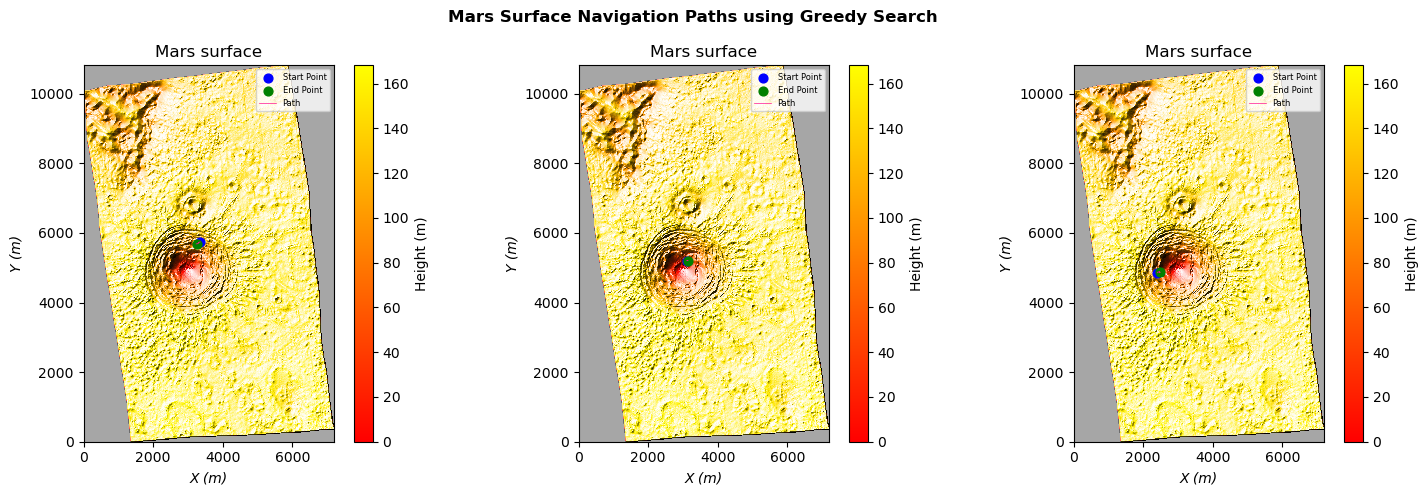

In [122]:
# Main function
def main():
    input_file = "mars_map.img"
    output_file = "mars_map.npy"

    # Process and visualize height map
    image_data, scale, new_scale, maxV, minV, n_rows, n_columns = process_height_map(input_file, output_file)

    # Load height map and calculate row and column from a given coordinate
    mars_map = np.load('mars_map.npy')
    
    # Define start points
    starts = [calculate_row_col(x, y, new_scale, mars_map.shape[0]) for x,y in [(3350, 5800),(3100, 5250),(2400, 4900)]]

    # Define maximum iterations and height difference allowed
    max_height_diff = 2.0  # meters
    max_iterations = 1000000
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Find and visualize paths using greedy descent search
    for i, start in enumerate(starts):
        path = greedyDescentSearch(start, mars_map, max_height_diff, max_iterations)
        visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, axs[i])
    fig.suptitle('Mars Surface Navigation Paths using Greedy Search', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
        
if __name__ == "__main__":
    main()

The explorer's capability to reach the bottom of the crater is limited by the inefficiency of the greedy search algorithm. Since the algorithm selects the next step based solely on the immediate neighboring pixel with the lowest depth that satisfies the height difference constraint, it may not always lead to the deepest point in the crater. In this case, the algorithm failed to reach the bottom of the crater within the specified iteration limit, indicating its inadequacy for this task.

To improve the implementation, increasing the height difference constraint from 2 meters to a larger value might allow the explorer to descend further into the crater. This adjustment would enable the explorer to consider a wider range of neighboring pixels, potentially leading to a more effective descent path. Additionally, exploring alternative search algorithms such as A* search or simulated annealing could offer better performance in finding the deepest point while efficiently navigating the terrain.

<br>

<p><h4> <b>Problem 2: Simulated Annealing</b> </h4></p>

Use the simulated annealing algorithm to find a path to the bottom of the crater with the explorer. Each iteration of the algorithm can be implemented as follows:

- Given the pixel where the explorer is located, select one of the neighboring pixels at random, with the condition that the difference in heights between the current position and that of the neighbor is not greater than 2.0 meters.
- If the new position is better than the previous one, move the browser to the previous position. Otherwise, try the simulated annealing rule if the new position is accepted.

Perform the same tests carried out by greedy search. What algorithm manages to reach deeper into the crater? Would you recommend the robot engineers use any of these algorithms?

In [123]:
# Define a function to calculate the height difference between two positions
def height_difference(height_map, current_position, new_position):
    current_height = height_map[current_position]
    new_height = height_map[new_position]
    return abs(new_height - current_height)


# Simulated annealing algorithm for explorer descent
def simulated_annealingggg(height_map, start_position, max_height_diff, max_steps):
    current_position = start_position
    current_height = height_map[current_position]
    path = [current_position]  # Initialize path with start position
    steps = 0

    while steps < max_steps:
        # Get neighboring positions
        neighbors = [
            (current_position[0] + 1, current_position[1]),  # Down
            (current_position[0] - 1, current_position[1]),  # Up
            (current_position[0], current_position[1] + 1),  # Right
            (current_position[0], current_position[1] - 1)   # Left
        ]
        # Filter neighbors based on height difference and valid positions
        valid_neighbors = [(x, y) for x, y in neighbors if 0 <= x < height_map.shape[0] and 0 <= y < height_map.shape[1] and height_difference(height_map, current_position, (x, y)) <= max_height_diff]
        if not valid_neighbors:
            break

        # Select a random neighbor
        new_position = random.choice(valid_neighbors)
        new_height = height_map[new_position]

        # Calculate energy (height difference)
        energy = height_difference(height_map, current_position, new_position)

        # If the new position is better or according to simulated annealing rule
        if new_height < current_height or random.random() < math.exp(-energy):
            current_position = new_position
            current_height = new_height
            path.append(current_position)  # Add current position to path
        
        # Increment and check current iteration
        steps += 1
        print("\nTime limit exceeded...") if steps >= max_steps else None
    
    return current_position, path

Sub-sampling: 10
New scale: 10.045020712681001 meters/pixel

Time limit exceeded...

Time limit exceeded...

Time limit exceeded...

Time limit exceeded...

Time limit exceeded...

Time limit exceeded...


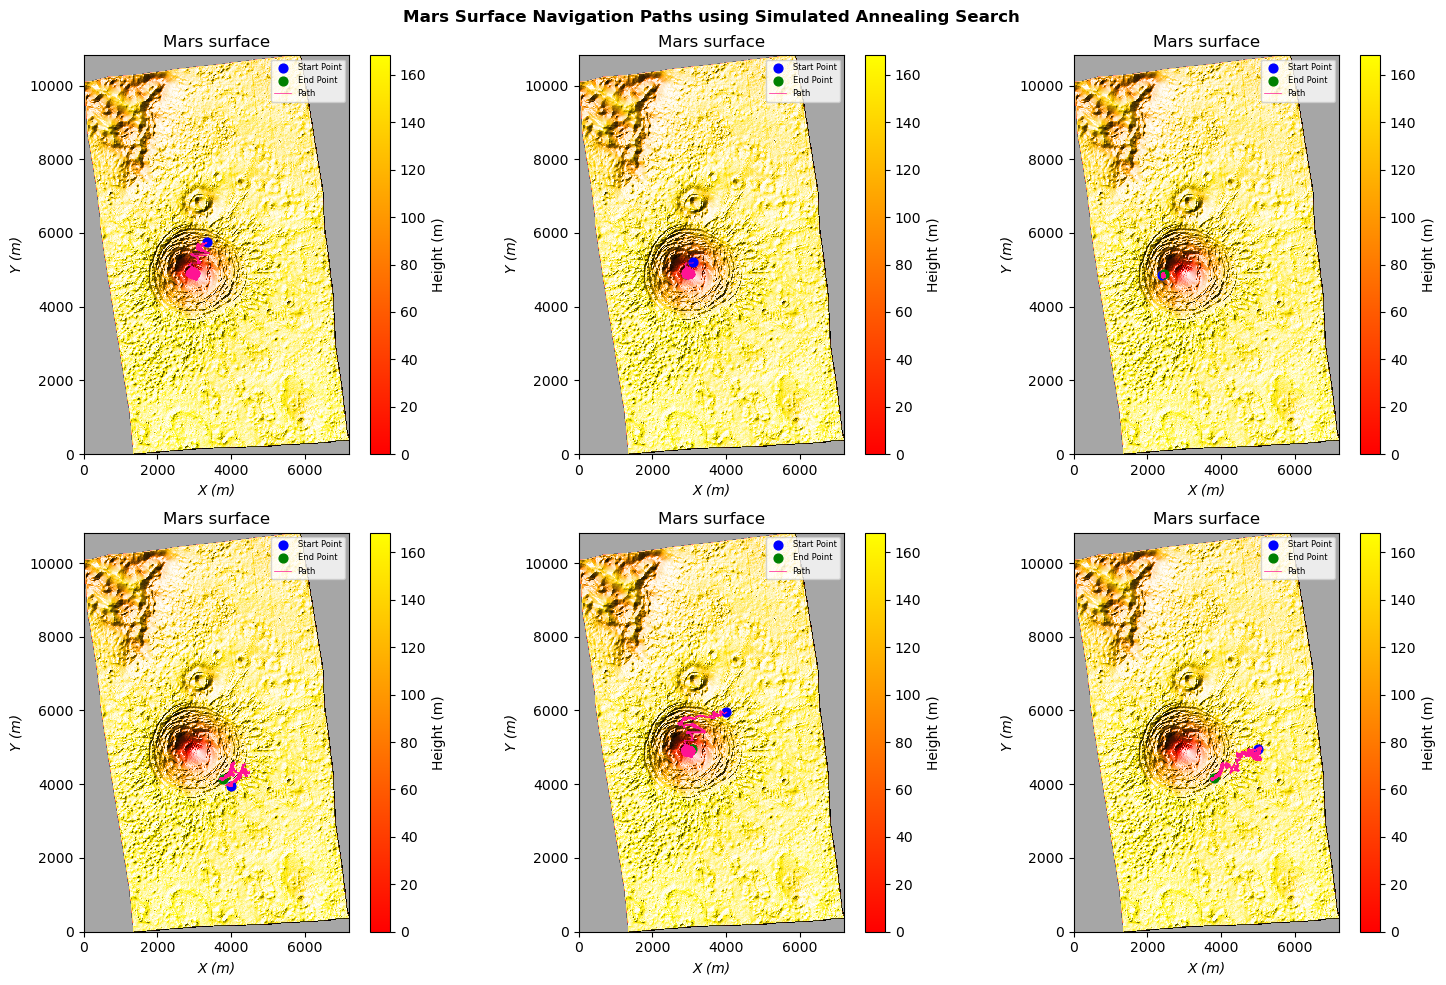

In [124]:
# Main function
def main():
    input_file = "mars_map.img"
    output_file = "mars_map.npy"

    # Process and visualize height map
    image_data, scale, new_scale, maxV, minV, n_rows, n_columns = process_height_map(input_file, output_file)

    # Load height map and calculate row and column from a given coordinate
    mars_map = np.load('mars_map.npy')
    
    # Define start points
    starts = [calculate_row_col(x, y, new_scale, mars_map.shape[0]) for x,y in [(3350, 5800),(3100, 5250),(2400, 4900),(4000, 4000),(4000, 6000),(5000, 5000)]]

    # Define maximum iterations and height difference allowed
    max_height_diff = 2.0  # meters
    max_iterations = 4000000
    
    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Find and visualize paths using simulated annealing
    for i, start in enumerate(starts):
        target, path = simulated_annealingggg(mars_map, start, max_height_diff, max_iterations)
        #path = [start,target]
        visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, axs[i // 3, i % 3])
    fig.suptitle('Mars Surface Navigation Paths using Simulated Annealing Search', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    main()


Simulated Annealing tends to reach deeper into the crater compared to Greedy Search. This is because Simulated Annealing allows the explorer to occasionally accept moves that are not immediately beneficial, which can help it explore more diverse paths and potentially find deeper regions within the crater. 

Based on the comparison between Simulated Annealing and Greedy Search, I would recommend the robot engineers to use Simulated Annealing for exploring the crater depths. Simulated Annealing demonstrates better performance in reaching deeper regions of the crater and is more likely to find optimal or near-optimal paths compared to Greedy Search, especially when dealing with larger distances from the starting point to the bottom of the crater. Additionally, Simulated Annealing provides a more flexible and robust approach by incorporating probabilistic acceptance of less favorable moves, allowing for better exploration of the search space.